<a href="https://colab.research.google.com/github/YosukeSugiura/B4-StudyGroup/blob/master/Honetoru_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Honetoru v.2

骨導マイクロホンを利用して，骨導音声を取得します．
雑音耐性が高い音声です．



# 起動する前に読んでください！

1. ミキサー or オーディオインターフェイス(AIF)にマイク(2ch)を接続してください．
    - 同じchのL/R端子にマイクを接続するようにしてください．
    - デバイスによってはマイク入力を別のプリアンプで増幅する必要があります．例えば，AIFにマイク入力端子がなく，LINE入力端子がある場合はプリアンプが必要です．
1. ミキサー or オーディオインターフェイスをPCに接続してください．
1. PCの「設定」→「サウンド」→「入力」からミキサー or オーディオインターフェイスの適切なチャンネルを選択してください．
1. このページをリロードしてください．
1. マイクのアクセス許可ポップウィンドウが出るので「許可」してください．
1. LEt's RUN！
    - モデルの読み込み等で時間がかかります．

# インストール

In [ ]:
#@title インストール
!pip install ffmpeg-python &> /dev/null
!pip install ipywidgets  &> /dev/null
!jupyter nbextension enable --py widgetsnbextension &> /dev/null
!pip install japanize-matplotlib &> /dev/null

# 音声強調関連
%pip install git+https://github.com/espnet/espnet &> /dev/null
%pip install -q espnet_model_zoo &> /dev/null

# 音声強調

In [ ]:
#@title インポート
# 音声強調系
import sys
import soundfile
from espnet_model_zoo.downloader import ModelDownloader
from espnet2.bin.enh_inference import SeparateSpeech

# ウィジェット系
from IPython.display import HTML, Audio, display, update_display
from google.colab.output import eval_js
from google.colab import output
from google.colab import widgets as wg
from ipywidgets import widgets as ipw
import ffmpeg
from functools import partial
from traitlets import traitlets

# 音声取り込み系
from base64 import b64decode
import numpy as np
import cupy as cp
from scipy.io.wavfile import read as wav_read
import io
from scipy.signal import decimate

# 音声強調系
from espnet_model_zoo.downloader import ModelDownloader
from scipy.signal import filtfilt

# 表示系
import matplotlib.pyplot as plt
from librosa import stft, istft, amplitude_to_db
from librosa.display import specshow, waveshow
import matplotlib.style as mplstyle
import japanize_matplotlib

# 警告非表示
import warnings
warnings.simplefilter('ignore')

In [ ]:
#@title 高速スペクトログラム計算
INPUT_ON_GPU = True
OUTPUT_ON_GPU = False

def Spectrogram(x, sample_rate, fft_size, frame_len, hop_size):

    frames = len(x) - frame_len + 1
    x = np.lib.stride_tricks.as_strided(
            x, (frames, frame_len), (x.strides[0], x.strides[0]))[::hop_size]
    x = np.pad(x,[(0,0),(0,fft_size-frame_len)])
    spec = spectrogram(x, sample_rate=sample_rate, frame_len=fft_size)
    return spec.T

def spectrogram(signal, sample_rate=22050, frame_len=1024):
    """
    Computes a magnitude spectrogram at a given sample rate (in Hz), frame
    length (in samples) and frame rate (in Hz), on CUDA using cupy.
    """
    signal = cp.array(signal.astype(np.float32))
    win = cp.hanning(frame_len).astype(cp.float32)
    # apply window function
    #signal *= win  # this doesn't work correctly for some reason.
    signal = signal * win
    # perform FFT
    spect = cp.fft.rfft(signal)
    # convert into magnitude spectrogram
    spect = cp.abs(spect)
    # return
    if OUTPUT_ON_GPU:
        cp.cuda.get_current_stream().synchronize()
    else:
        return spect.get()

In [ ]:
#@title モデル選択 & 読み込み

# モデル選択はここから
# https://github.com/espnet/espnet_model_zoo/blob/master/espnet_model_zoo/table.csv
tag = "espnet/Wangyou_Zhang_chime4_enh_train_enh_conv_tasnet_raw"

d = ModelDownloader()
cfg = d.download_and_unpack(tag)

separate_speech = {}
# For models downloaded from GoogleDrive, you can use the following script:
enh_model_sc = SeparateSpeech(
  train_config=cfg["train_config"],
  model_file=cfg["model_file"],
  # for segment-wise process on long speech
  normalize_segment_scale=False,
  show_progressbar=True,
  ref_channel=4,
  normalize_output_wav=True,
  device="cuda:0",
)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.9/threading.py", line 1306, in run
    self.function(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.9/dist-packages/music21/ipython21/__init__.py", line 34, in loadNoMagic
    load_ipython_extension(localIP)
  File "/usr/local/lib/python3.9/dist-packages/music21/ipython21/ipExtension.py", line 21, in load_ipython_extension
    ip.run_line_magic('config', "InlineBackend.figure_format = 'retina'")
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2314, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-41>", line 2, in config
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/magics/config.py", line 152

In [ ]:
#@title 音声強調関数
def speech_enhancement(speech, sr):
    return enh_model_sc(speech, sr)

In [ ]:
#@title 長時間スペクトルによる補正
def b2a_transformer(bone, air):
    Bone = stft(bone)
    Air = stft(air)
    
    LTS_air =  np.mean(np.abs(Air)**2,axis=-1, keepdims=True)
    LTS_air = LTS_air/np.mean(LTS_air)

    LTS_bone = np.mean(np.abs(Bone)**2,axis=-1, keepdims=True)
    LTS_bone = LTS_bone/np.mean(LTS_bone)

    Gain =  LTS_air / LTS_bone
    Bone = Bone * Gain

    b2a = np.real(istft(Bone))
    b2a = np.pad(b2a,[(0,0),(0,bone.size-b2a.size)])

    b2a = b2a * np.max(bone)/ np.sum(b2a**2))

    return b2a

# 音声録音 & 再生

ここは基本，非表示でよき．

In [ ]:
#@title Javascript関数設定

AUDIO_HTML = """
<script>
// 表示系オブジェクト
var my_div = document.createElement("DIV");
document.body.appendChild(my_div);

// 変数
var base64data = 0;
var reader;
var recorder, gumStream;

// 録音ハンドラーオブジェクト
var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    mimeType : 'audio/webm;codecs=opus'
  };            
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
    }
  };
  };

// 録音ハンドラーの起動
navigator.mediaDevices.getUserMedia({
        audio: {
            channelCount: {ideal: 2, min: 1},
            echoCancellation: { exact: false },
            noiseSuppression: { exact: false },
            autoGainControl:{ exact:  false },  
        }
    }).then(handleSuccess);

// ↓↓ここからインタラクティブ系の命令
// -----------------------------------------

// 録音開始
function startRecording() {
    setTimeout(() => {
        recorder.start();
    }, 10);
}

// 録音停止
async function stopRecording() {
    return new Promise(resolve=>{
        recorder.stop();
        resolve();
    });
}

// 録音停止
async function stopStream() {
    return new Promise(resolve=>{
        gumStream.getAudioTracks()[0].stop();
        resolve();
    });
}
// データ抜き出し 
// 注意！取り出しには少し時間がかかるので，Timeoutを設定
async function getdata() {
    return new Promise(resolve=>{
        setTimeout(() => {
            resolve(base64data.toString()); 
        }, 10);
    });
}

// 録音データの抽出
async function extract_data() {
  await stopRecording();
  //await stopStream();
  var val = await getdata();
  return val;
}
      
</script>
"""

In [ ]:
#@title 関数(1) - 録音関係 (Javascriptとの連携)

# 録音開始
def rec_start(obj):
    eval_js('startRecording()')

# 録音停止 - データ抽出
def rec_stop(obj, hdl=None):

    # チャンク→数値列
    def chunk2val(data):
        q = len(data) - 8
        b = []
        for i in range(4):
            q, r = divmod(q, 256)
            b.append(r)
        return data[:4] + bytes(b) + data[8:]

    # データの終わりを1s分カット(クリック音が入る)
    def truncation(data, sr, s=1.0):
        l = int(sr*s)
        return data[:-l,:]

    data = eval_js('extract_data()')
    binary = b64decode(data.split(',')[1])

    # 録音データをwav形式バイナリに変換
    process = (ffmpeg
        .input('pipe:0')
        .output('pipe:1', format='wav')
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
        )
    # バイナリから数値列に変換
    output, err = process.communicate(input=binary)
    sr, audio = wav_read(io.BytesIO(chunk2val(output)))
    audio = truncation(audio, sr, s=2)
    audio = decimate(audio, 3, axis=0)   # ダウンサンプリング
    sr = int(sr/3)
    # データ格納 (ボタンオブジェクト内の変数に)
    obj.audio=audio
    obj.sr = sr


In [ ]:
#@title 関数(2) - ウィジェット・波形・スペクトログラム

# ボタンクラスをちょいと改変
class RecordButton(ipw.Button):
    def __init__(self, audio=np.zeros([2,44100]), *args, **kwargs):
        super(RecordButton, self).__init__(*args, **kwargs)
        self.add_traits(audio=traitlets.Any(audio))    # 録音音声 変数追加
        self.add_traits(sr=traitlets.Any(44100))       # サンプリングレート追加
        self.add_traits(audio_enh=traitlets.Any(audio))    # 強調音声 変数追加

# 任意のタブに波形 or スペクトログラムを表示
class tab_plot:

    # タブにFigureをせっとする
    def __init__(self, tab_obj, tab_id, Tag_name, fig_num=2, size=(6.8,5)):
        self.t      = tab_obj
        self.id     = tab_id
        self.size   = size
        self.n      = fig_num
        self.S      = []
        self.name   = Tag_name

        self.ax     = []

        # タブ内にグリッドを設定(図を二つ並べる)
        with self.t.output_to(self.id, select=False):
            self.g = wg.Grid(1, self.n, header_row=False, header_column=False,
                            style='border-style: none;')

    # 波形表示
    def wav_plot(self, data, sr, select=False, update=False):

        # 波形をプロット
        with self.t.output_to(self.id, select):
            for idx, (d, name) in enumerate(zip(data.T,self.name)):
                # 一つのグリッドに一つの図
                with self.g.output_to(0, idx):
                    self.g.clear_cell()
                    fig, ax = plt.subplots(figsize=self.size, tight_layout=True)
                    waveshow(d/np.iinfo(np.int16).max, sr, max_points=1024, ax=ax)
                    ax.set_title(name, fontsize=18)

    # スペクトログラム表示
    def spec_plot(self, data, sr, half=False, select=False):

        # スペクトログラム計算
        # (表示系の動作が遅いので先にやっておく)
        S_db = []
        for d in data.T:
            #D = stft(d/np.iinfo(np.int16).max, n_fft=2048, hop_length=128, win_length=1024)
            D = Spectrogram(d/np.iinfo(np.int16).max, sr, 2048, 1024, 192)
            S_db.append(amplitude_to_db(np.abs(D), ref=np.max))

        # スペクトログラム表示
        self.S = S_db       # 再表示用にスペクトログラムを保存
        self.spec_replot(sr, half, select)

    # スペクトログラム再表示 (スペクトログラムの計算しない)
    def spec_replot(self, sr, half=False, select=False):
        
        # スペクトログラム(self.Sに保存したもの)をプロット
        with self.t.output_to(self.id, select):
            for idx, (S, name) in enumerate(zip(self.S,self.name)):
                # 一つのグリッドに一つの図
                with self.g.output_to(0, idx):
                    self.g.clear_cell()
                    fig, ax = plt.subplots(figsize=self.size, tight_layout=True)
                    specshow(S, sr=sr, x_axis='time', y_axis='hz',ax=ax)
                    ax.set_title(name, fontsize=18)
                    if half:
                        ax.set_ylim([0, sr/4])

# プレイヤーを表示
class Player:
    def __init__(self, Tags):

        self.g = wg.Grid(1, 8, header_row=False, header_column=False,
                            style='border-style: none;')

        with self.g.output_to(0,0):
            html=HTML('<p style="margin-right: 15px;">'+Tags[0]+'</p>')
            display(html)
        with self.g.output_to(0,1):
            player1 = Audio([0],rate = 48000)
            self.hdl1 = display(player1, display_id=True)
        with self.g.output_to(0,2):
            print('    ')
        with self.g.output_to(0,3):
            html=HTML('<p style="margin-right: 15px;">'+Tags[1]+'</p>')
            display(html)
        with self.g.output_to(0,4):
            player2 = Audio([0],rate = 48000)
            self.hdl2 = display(player2, display_id=True)
        with self.g.output_to(0,5):
            print('    ')
        with self.g.output_to(0,6):
            html=HTML('<p style="margin-right: 15px;">'+Tags[1]+'</p>')
            display(html)
        with self.g.output_to(0,7):
            player3 = Audio([0],rate = 48000)
            self.hdl3 = display(player3, display_id=True)
    
    def __call__(self, audio, sr):
        # プレイヤーのデータを更新
        self.hdl1.update(Audio(audio[:, 0],rate = sr))
        self.hdl2.update(Audio(audio[:, 1],rate = sr))
        self.hdl3.update(Audio(audio[:, 2],rate = sr))

In [ ]:
#@title 関数(3) - インタラクティブの設定

# ボタンを押したときの挙動
class button_react:
    def __init__(self, player, tb_wav_list, tb_spec_list, ckb):
        self.p      = player       # プレイヤーオブジェクト
        self.t_wav  = tb_wav_list   # 波形表示用
        self.t_spec = tb_spec_list  # スペクトログラム表示用
        self.toggle = 1             # 1:録音可能, 0:録音中, -1:処理中(反応しない)
        self.cb = ckb

    # スペクトログラムを再描写する
    def spec_replot(self, tb_spec, audio_st, sr):
        tb_spec.spec_replot(sr, half=self.cb.value)

    # 波形・スペクトログラムを更新する
    def plot(self, tb_wav, tb_spec, audio_st, sr):
        tb_wav.wav_plot(audio_st, sr)
        tb_spec.spec_plot(audio_st, sr, half=self.cb.value)

    # プロットの初期化
    def init_plot(self):
        for tw, ts in zip(self.t_wav, self.t_spec):
                self.plot(tw, ts, np.zeros([3000,2]), 1000)    # グラフを更新

    # 録音/録音終了 → 波形・スペクトログラムを更新する
    def __call__(self, obj):

        if self.toggle == 1: # 録音開始

            self.toggle = -1    # フラグを処理中に
            obj.description = '停止'
            rec_start(obj)      # 録音処理開始
            self.toggle = 0    # フラグを録音中に

        elif self.toggle == 0: # 録音終了

            self.toggle = -1   # フラグを処理中に
            obj.description = '処理中'

            # 録音停止→データ抽出
            rec_stop(obj)
            
            # 音声強調
            auido_enh_bone = speech_enhancement(obj.audio[None,:,1].copy(), obj.sr)
            auido_enh_air = obj.audio[None,:,0].copy()
            auido_enh_bone = auido_enh_bone[0]

            # 骨導to気導
            auido_b2a = b2a_transformer(auido_enh_bone, auido_enh_air)
            obj.audio_enh = np.c_[auido_enh_air.T, auido_b2a.T]
            audios = [obj.audio, obj.audio_enh]

            # グラフ更新
            for tw, ts, audio in zip(self.t_wav, self.t_spec, audios):
                self.plot(tw, ts, audio, obj.sr)    # グラフを更新

            # プレイヤーの更新
            player(np.c_[obj.audio, auido_b2a.T], obj.sr)               
            
            # 終了処理
            self.toggle = 1   # フラグを録音可能に
            obj.description = '録音開始'

# メイン関数

メインウィンドウを表示させます．

,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RecordButton(description='録音開始', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Checkbox(value=True, description='スペクトログラムの表示周波数範囲を1/2に', indent=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

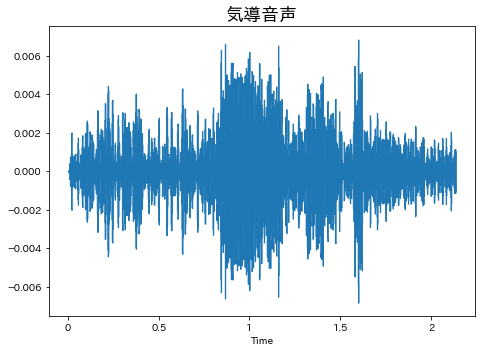

<IPython.core.display.Javascript object>

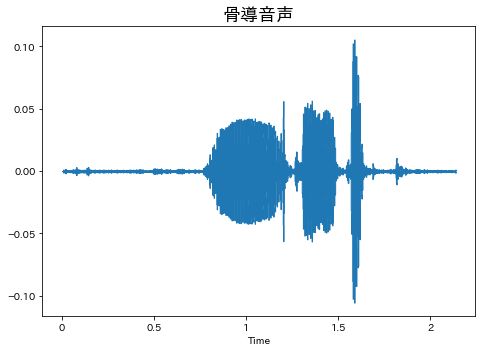

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

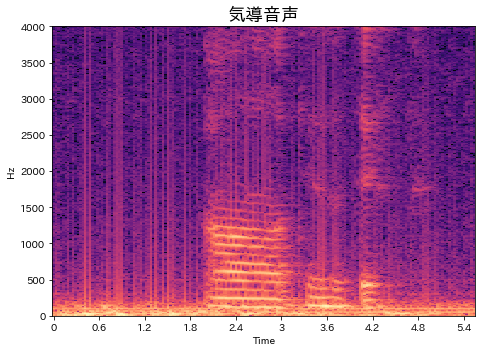

<IPython.core.display.Javascript object>

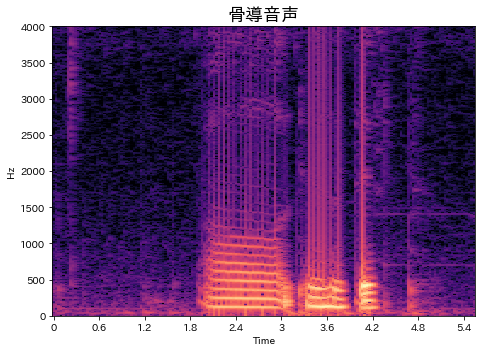

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

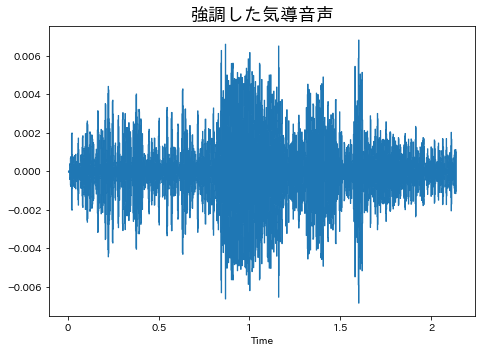

<IPython.core.display.Javascript object>

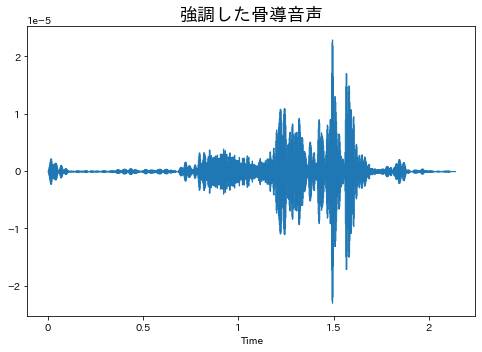

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

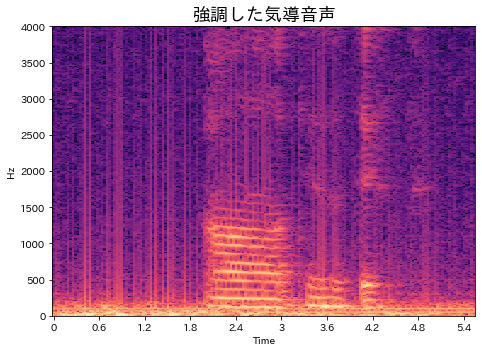

<IPython.core.display.Javascript object>

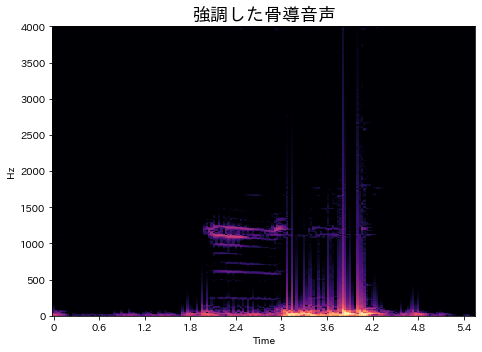

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Honetoru v.2

## Javascript読み込み
display(HTML(AUDIO_HTML))

## 注意事項表示
display(HTML('''\
<div>
  <p><font color="red">[注意1]</font> マイクのアクセスを許可してね!</p>
  <p><font color="red">[注意2]</font> F11を押すと全画面表示になって，画面が見やすくなるよ!</p>
  <p><font color="red">[注意3]</font> Colab右上「ヘッダーを非表示」アイコン( ^ ←こんなマーク)を押すと画面が広くなって見やすくなるよ!</p>
  <br>
</div>
'''))

## ---------------------------------------

## ウィンドウ設定
# ボタン生成
btn1 = RecordButton(description='録音開始')
ckb1 = ipw.Checkbox(value=True, 
                    description='スペクトログラムの表示周波数範囲を1/2に',
                    indent = False)

## ウィンドウ内の描写
# ボタン & チェックボックス表示
g = wg.Grid(1,3,style='border-style: none;')
with g.output_to(0,0):
    display(btn1)
with g.output_to(0,1):
    print('   ')
with g.output_to(0,2):
    display(ckb1)

# ボタンの下にタブを表示
t_obj = wg.TabBar(["波形", "スペクトログラム","強調音声の波形","強調音声のスペクトログラム"])
# それぞれのタブの設定
t0 = tab_plot(t_obj, 0, ['気導音声','骨導音声']) # wav
t1 = tab_plot(t_obj, 1, ['気導音声','骨導音声']) # spec
t2 = tab_plot(t_obj, 2, ['強調した気導音声','強調した骨導音声']) # wav
t3 = tab_plot(t_obj, 3, ['強調した気導音声','強調した骨導音声']) # spec

# オーディオプレイヤーの設定
ply = Player(['気導音声','骨導音声','強調 + 変換'])

# ボタン設定
btn_fnc = button_react(ply, [t0, t2], [t1,t3], ckb1)
btn_fnc.init_plot() # 初期状態(なんもなし)を表示
btn1.on_click(btn_fnc)

# チェックボックス用イベントハンドラ
def changed(obj):
    if obj.name == 'value':
        # スペクトログラム再描写
        t1.spec_replot(btn1.audio, btn1.sr, half=obj.value)
        t3.spec_replot(btn1.audio_enh, btn1.sr, half=obj.value)
ckb1.observe(changed)